In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[0])
label_data = Label_Data.parse(Label_Data.sheet_names[0])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'ATP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(148, 300)
(148, 1)


In [3]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[7])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'ATP Label', 'HYP Label', 'INDEX MEDU'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['HYP'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[6])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(20, 300)
(20, 1)
<class 'pandas.core.frame.DataFrame'>


In [4]:
interpolated_data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 1
0,0.640369,0.498260,0.486767,0.679340,0.647836,0.771028,0.580125,0.523624,0.549084,0.531644,...,0.132742,0.144950,0.167203,0.195446,0.147017,0.103436,0,0.750000,14.0,1
1,-0.201289,-0.009675,0.236328,0.110132,-0.172074,0.404189,0.214570,-0.067842,0.175427,0.096374,...,0.159958,0.204727,0.255312,0.231132,0.283782,0.418953,1,0.750000,8.0,1
2,-0.094138,0.032406,0.183322,0.126899,-0.064361,0.382030,0.165874,-0.175117,0.090313,0.019391,...,0.156959,0.246642,0.433583,0.350745,0.233091,0.161711,0,0.833333,10.0,1
3,-0.011933,0.209546,0.390546,0.284583,-0.032678,0.486978,0.246892,0.073225,0.347454,0.301431,...,0.199174,0.232535,0.420176,0.284627,0.275648,0.274123,0,0.916667,10.0,1
4,-0.214126,-0.075196,0.160270,0.019380,-0.189347,0.335372,0.152731,-0.167334,0.141346,0.036927,...,0.123159,0.228639,0.253390,0.268384,0.216538,0.252791,1,0.833333,16.0,1


In [5]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(230, 300)
(230, 300)
(230, 300)
(230, 300)
(232, 300)
(232, 300)
(232, 300)
(232, 300)


In [6]:
training_indices_X[0].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 1
0,-0.296516,0.019798,0.148673,0.088420,-0.248281,0.427044,0.241853,-0.144875,0.087991,0.179765,...,0.307139,0.195980,0.442938,0.048999,0.429408,0.205990,1.0,0.750000,16.0,1.010959
1,-0.136743,-0.230085,0.179516,0.077768,-0.106326,0.227827,0.109582,-0.309415,0.169339,0.106207,...,0.044584,0.263017,0.341437,0.581531,0.469763,0.531485,0.0,0.500000,14.0,1.035616
2,0.015747,-0.101754,0.306488,0.200862,-0.178784,0.465817,0.257937,-0.014865,0.412029,0.099495,...,0.422804,0.366829,0.730443,0.263909,0.410264,0.388674,1.0,0.916667,16.0,1.126027
3,-0.194265,-0.064244,0.200733,0.074212,-0.201491,0.401558,0.218512,-0.031789,0.302988,-0.029465,...,0.112450,0.110412,0.246215,0.145806,0.275628,0.223729,0.0,0.583333,13.0,1.150685
4,-0.247304,0.054458,0.328019,0.138133,0.001408,0.409507,0.126695,-0.044608,0.231406,0.127242,...,0.232279,0.566873,0.859028,0.604834,0.626633,0.225424,1.0,0.750000,12.0,1.073973


In [7]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(230, 300)
(230, 300)
(230, 300)
(230, 300)
(232, 300)
(232, 300)
(232, 300)
(232, 300)
----------
(250, 300)
(250, 300)
(250, 300)
(250, 300)
(252, 300)
(252, 300)
(252, 300)
(252, 300)
Label shapes
(230, 1)
(230, 1)
(230, 1)
(230, 1)
(232, 1)
(232, 1)
(232, 1)
(232, 1)
----------
(250, 1)
(250, 1)
(250, 1)
(250, 1)
(252, 1)
(252, 1)
(252, 1)
(252, 1)


In [8]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [9]:
testing_fold_Y_1.shape

(19, 1)

In [10]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 

D_in, H1, H2, D_out = 300, 100, 25, 1
EPOCHS = 100
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.20

test_size = 19
test_size1 = 18

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [11]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(19, 300)
(19, 300)
(19, 300)
(19, 300)
(18, 300)
(18, 300)
(18, 300)
(18, 300)


In [12]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [13]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.to(device)
print(model)
weights = torch.FloatTensor([5]) #Class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model1's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.to(device)
print(model1)
weights1 = torch.FloatTensor([5]) #Class weights
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model2's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.to(device)
print(model2)
weights2 = torch.FloatTensor([5]) #Class weights
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model3's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.to(device)
print(model3)
weights3 = torch.FloatTensor([5]) #Class weights
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model4's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.to(device)
print(model4)
weights4 = torch.FloatTensor([5]) #Class weights
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model5's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.to(device)
print(model5)
weights5 = torch.FloatTensor([5]) #Class weights
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model6's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.to(device)
print(model6)
weights6 = torch.FloatTensor([5]) #Class weights
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model7's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.to(device)
print(model7)
weights7 = torch.FloatTensor([5]) #Class weights
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (layer_out): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
binaryClassification(
  (layer_1): Linear(in_features=300, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=25, bias=True)
  (laye

In [14]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.61600 | Acc: 48.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.41156 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.40263 | Acc: 47.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.35257 | Acc: 47.556


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.34998 | Acc: 46.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.35087 | Acc: 46.667
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.29720 | Acc: 47.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.28561 | Acc: 45.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.23881 | Acc: 48.556
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.20627 | Acc: 47.444
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.18067 | Acc: 48.556
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 012: | Loss: 1.08998 | Acc: 47.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.03331 | Acc: 53.333
Validation Accuracy |  15.789473684210526  PPV |  [1.         0.11111111]  Recall |  [0.05882353 1.        ]
Training Epoch 014: | Loss: 0.92165 | Acc: 54.444
Validation Accuracy |  52.63157894736842  PPV |  [0.9        0.11111111]  Recall |  [0.52941176 0.5       ]
Training Epoch 015: | Loss: 0.85280 | Acc: 63.000
Validation Accuracy |  31.57894736842105  PPV |  [1.         0.13333333]  Recall |  [0.23529412 1.        ]
Training Epoch 016: | Loss: 0.71062 | Acc: 79.667
Validation Accuracy |  42.10526315789473  PPV |  [1.         0.15384615]  Recall |  [0.35294118 1.        ]
Training Epoch 017: | Loss: 0.65638 | Acc: 71.333
Validation Accuracy |  84.21052631578947  PPV |  [0.9375     0.33333333]  Recall |  [0.88235294 0.5       ]
Training Epoch 018: | Loss: 0.55858 | Acc: 80.778
Validation Accur

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  68.42105263157895  PPV |  [0.92307692 0.16666667]  Recall |  [0.70588235 0.5       ]
Training Epoch 030: | Loss: 0.15543 | Acc: 98.556
Validation Accuracy |  78.94736842105263  PPV |  [0.88235294 0.        ]  Recall |  [0.88235294 0.        ]
Training Epoch 031: | Loss: 0.13209 | Acc: 97.556
Validation Accuracy |  84.21052631578947  PPV |  [0.9375     0.33333333]  Recall |  [0.88235294 0.5       ]
Training Epoch 032: | Loss: 0.12940 | Acc: 98.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 033: | Loss: 0.11743 | Acc: 99.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 034: | Loss: 0.09649 | Acc: 99.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 035: | Loss: 0.07401 | Acc: 99.000
Validation Accuracy |  84.21052631578947  PPV |  [0.

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 040: | Loss: 0.05461 | Acc: 99.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 041: | Loss: 0.05095 | Acc: 99.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 042: | Loss: 0.13670 | Acc: 98.556
Validation Accuracy |  78.94736842105263  PPV |  [0.88235294 0.        ]  Recall |  [0.88235294 0.        ]
Training Epoch 043: | Loss: 0.13825 | Acc: 95.556
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 044: | Loss: 0.17924 | Acc: 96.667
Validation Accuracy |  68.42105263157895  PPV |  [0.92307692 0.16666667]  Recall |  [0.70588235 0.5       ]
Training Epoch 045: | Loss: 0.07513 | Acc: 98.444
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 046: | Loss: 0.06153 | Acc: 99.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 047: | Loss: 0.12623 | Acc: 98.889
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 048: | Loss: 0.07607 | Acc: 97.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 049: | Loss: 0.05875 | Acc: 99.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 050: | Loss: 0.04139 | Acc: 99.333
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 051: | Loss: 0.02976 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 052: | Loss: 0.02987 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 054: | Loss: 0.02503 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 055: | Loss: 0.02763 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 056: | Loss: 0.02149 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 057: | Loss: 0.02203 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 058: | Loss: 0.01552 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 059: | Loss: 0.01574 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 060: | Loss: 0.02077 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 061: | Loss: 0.01349 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 062: | Loss: 0.03181 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 063: | Loss: 0.01813 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 064: | Loss: 0.01887 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 065: | Loss: 0.01551 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 066: | Loss: 0.01004 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 067: | Loss: 0.01169 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 068: | Loss: 0.01480 | Acc: 100.000
Validation 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 071: | Loss: 0.01201 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 072: | Loss: 0.01706 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 073: | Loss: 0.01398 | Acc: 99.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 074: | Loss: 0.01342 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 075: | Loss: 0.01586 | Acc: 99.667
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 076: | Loss: 0.00837 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 077: | Loss: 0.00931 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 078: | Loss: 0.00799 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 079: | Loss: 0.00921 | Acc: 100.000

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 080: | Loss: 0.00850 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 081: | Loss: 0.00810 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 082: | Loss: 0.00837 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 083: | Loss: 0.00879 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 084: | Loss: 0.01131 | Acc: 100.000
Validation Accuracy |  

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 085: | Loss: 0.00702 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 086: | Loss: 0.00733 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 087: | Loss: 0.00652 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 088: | Loss: 0.00525 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 089: | Loss: 0.00757 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 090: | Loss: 0.00510 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 091: | Loss: 0.00490 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 092: | Loss: 0.00661 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 093: | Loss: 0.00525 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 094: | Loss: 0.00349 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 095: | Loss: 0.00449 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 096: | Loss: 0.00377 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 097: | Loss: 0.00466 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 098: | Loss: 0.00962 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 099: | Loss: 0.00514 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 100: | Loss: 0.00254 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.67432 | Acc: 45.889


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.42154 | Acc: 47.556
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.41175 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.38270 | Acc: 47.333

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.34721 | Acc: 45.889
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34315 | Acc: 44.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.30892 | Acc: 46.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.30469 | Acc: 46.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.28098 | Acc: 45.667
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 010: | Loss: 1.22888 | Acc: 47.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.19781 | Acc: 48.556
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.15945 | Acc: 46.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 013: | Loss: 1.06065 | Acc: 50.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 0.97730 | Acc: 50.222
Validation Accuracy |  10.526315789473683  PPV |  [0.5        0.05882353]  Recall |  [0.05882353 0.5       ]
Training Epoch 015: | Loss: 0.93697 | Acc: 65.889
Validation Accuracy |  5.263157894736842  PPV |  [0.         0.05555556]  Recall |  [0.  0.5]
Training Epoch 016: | Loss: 0.81167 | Acc: 68.222
Validation Accuracy |  31.57894736842105  PPV |  [0.83333333 0.07692308]  Recall |  [0.29411765 0.5       ]
Training Epoch 017: | Loss: 0.71772 | Acc: 70.111
Validation Accuracy |  47.368421052631575  PPV |  [0.88888889 0.1       ]  Recall |  [0.47058824 0.5       ]
Training Epoch 018: | Loss: 0.62759 | Acc: 78.889
Validation Accuracy |  52.63157894736842  PPV |  [0.9        0.11111111]  Recall |  [0.52941176 0.5       ]
Training Epoch 019: | Loss: 0.53453 | Acc: 79.889
Validation Accuracy |  52.631

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 028: | Loss: 0.15032 | Acc: 97.444
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 029: | Loss: 0.17624 | Acc: 97.889
Validation Accuracy |  84.21052631578947  PPV |  [0.9375     0.33333333]  Recall |  [0.88235294 0.5       ]
Training Epoch 030: | Loss: 0.19688 | Acc: 95.222
Validation Accuracy |  84.21052631578947 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 031: | Loss: 0.14402 | Acc: 97.556
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 032: | Loss: 0.12921 | Acc: 98.556
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 033: | Loss: 0.09906 | Acc: 99.667
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 034: | Loss: 0.07727 | Acc: 99.333
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 035: | Loss: 0.09504 | Acc: 99.333
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 036: | Loss: 0.07769 | Acc: 99.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 037: | Loss: 0.08364 | Acc: 99.333
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 038: | Loss: 0.05530 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 039: | Loss: 0.06359 | Acc: 98.667
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 040: | Loss: 0.05275 | Acc: 99.667
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 041: | Loss: 0.05827 | Acc: 99.667
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 042: | Loss: 0.05457 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 043: | Loss: 0.05352 | Acc: 99.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 044: | Loss: 0.04287 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 045: | Loss: 0.04882 | Acc: 99.667
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 046: | Loss: 0.02679 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 047: | Loss: 0.03755 | Acc: 99.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 048: | Loss: 0.02867 | Acc: 99.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 049: | Loss: 0.02690 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 050: | Loss: 0.02938 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 051: | Loss: 0.02139 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 052: | Loss: 0.02536 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 053: | Loss: 0.06613 | Acc: 98.556
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 054: | Loss: 0.05108 | Acc: 99.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 055: | Loss: 0.03572 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 056: | Loss: 0.02005 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 057: | Loss: 0.02570 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 058: | Loss: 0.01440 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 059: | Loss: 0.02153 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 060: | Loss: 0.02535 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 061: | Loss: 0.01722 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 062: | Loss: 0.01061 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 063: | Loss: 0.00914 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 064: | Loss: 0.00901 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 065: | Loss: 0.01236 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 066: | Loss: 0.01071 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 067: | Loss: 0.01007 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 068: | Loss: 0.01129 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 069: | Loss: 0.00909 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 070: | Loss: 0.00794 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 071: | Loss: 0.00763 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 072: | Loss: 0.01147 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 073: | Loss: 0.0074

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 074: | Loss: 0.00571 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 075: | Loss: 0.00653 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 076: | Loss: 0.00599 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 077: | Loss: 0.01703 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 078: | Loss: 0.01814 | Acc: 99.667
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 079: | Loss: 0.01302 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 080: | Loss: 0.01050 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 081: | Loss: 0.00872 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 082: | Loss: 0.00889 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 083: | Loss: 0.00878 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 084: | Loss: 0.00741 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 085: | Loss: 0.00622 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 086: | Loss: 0.00492 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 087: | Loss: 0.00486 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 088: | Loss: 0.00394 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 089: | Loss: 0.00510 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 090: | Loss: 0.00562 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 091: | Loss: 0.00439 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 092: | Loss: 0.00590 | Acc: 100.000
Validation Accuracy | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 093: | Loss: 0.00784 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 094: | Loss: 0.00392 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 095: | Loss: 0.00360 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 096: | Loss: 0.00321 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 097: | Loss: 0.00343 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 098: | Loss: 0.00308 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 099: | Loss: 0.00352 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]
Training Epoch 100: | Loss: 0.00552 | Acc: 100.000
Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 001: | Loss: 1.77236 | Acc: 47.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.46082 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.37231 | Acc: 48.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 004: | Loss: 1.39580 | Acc: 45.111
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.34877 | Acc: 46.889
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.35021 | Acc: 47.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 007: | Loss: 1.32099 | Acc: 45.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.30619 | Acc: 47.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.28919 | Acc: 46.333
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 010: | Loss: 1.23838 | Acc: 46.444
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.20529 | Acc: 47.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.14722 | Acc: 49.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 013: | Loss: 1.11033 | Acc: 47.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.01733 | Acc: 55.222
Validation Accuracy |  10.526315789473683  PPV |  [0.5        0.05882353]  Recall |  [0.05882353 0.5       ]
Training Epoch 015: | Loss: 0.99117 | Acc: 55.889
Validation Accuracy |  15.789473684210526  PPV |  [0.66666667 0.0625    ]  Recall |  [0.11764706 0.5       ]
Training Epoch 016: | Loss: 0.88757 | Acc: 60.333
Validation Accuracy |  15.789473684210526  PPV |  [0.66666667 0.0625    ]  Recall |  [0.11764706 0.5       ]
Training Epoch 017: | Loss: 0.78908 | Acc: 66.333
Validation Accuracy |  57.89473684210527  PPV |  [0.90909091 0.125     ]  Recall |  [0.58823529 0.5       ]
Training Epoch 018: | Loss: 0.72779 | Acc: 71.889
Validation Accuracy |  36.84210526315789  PPV |  [0.85714286 0.08333333]  Recall |  [0.35294118 0.5       ]
Training Epoch 019: | Loss: 0.64782 | Acc: 77.111
Validation Acc

Validation Accuracy |  94.73684210526315  PPV |  [0.94444444 1.        ]  Recall |  [1.  0.5]
Training Epoch 070: | Loss: 0.01391 | Acc: 100.000
Validation Accuracy |  94.73684210526315  PPV |  [0.94444444 1.        ]  Recall |  [1.  0.5]
Training Epoch 071: | Loss: 0.00869 | Acc: 100.000
Validation Accuracy |  94.73684210526315  PPV |  [0.94444444 1.        ]  Recall |  [1.  0.5]
Training Epoch 072: | Loss: 0.00923 | Acc: 100.000
Validation Accuracy |  94.73684210526315  PPV |  [0.94444444 1.        ]  Recall |  [1.  0.5]
Training Epoch 073: | Loss: 0.01171 | Acc: 100.000
Validation Accuracy |  94.73684210526315  PPV |  [0.94444444 1.        ]  Recall |  [1.  0.5]
Training Epoch 074: | Loss: 0.01448 | Acc: 100.000
Validation Accuracy |  94.73684210526315  PPV |  [0.94444444 1.        ]  Recall |  [1.  0.5]
Training Epoch 075: | Loss: 0.00706 | Acc: 100.000
Validation Accuracy |  94.73684210526315  PPV |  [0.94444444 1.        ]  Recall |  [1.  0.5]
Training Epoch 076: | Loss: 0.01107 

In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.72469 | Acc: 44.889
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.39658 | Acc: 46.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.40150 | Acc: 45.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 004: | Loss: 1.35359 | Acc: 45.778
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.31774 | Acc: 46.556
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.31578 | Acc: 46.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.26199 | Acc: 46.556


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.24457 | Acc: 46.000
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.16637 | Acc: 48.222
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.08355 | Acc: 46.222


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.01586 | Acc: 51.889
Validation Accuracy |  10.526315789473683  PPV |  [0.         0.10526316]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 0.92741 | Acc: 55.667
Validation Accuracy |  36.84210526315789  PPV |  [0.85714286 0.08333333]  Recall |  [0.35294118 0.5       ]
Training Epoch 013: | Loss: 0.79469 | Acc: 63.667
Validation Accuracy |  21.052631578947366  PPV |  [0.75       0.06666667]  Recall |  [0.17647059 0.5       ]
Training Epoch 014: | Loss: 0.71543 | Acc: 70.333
Validation Accuracy |  68.42105263157895  PPV |  [0.86666667 0.        ]  Recall |  [0.76470588 0.        ]
Training Epoch 015: | Loss: 0.66355 | Acc: 74.111
Validation Accuracy |  47.368421052631575  PPV |  [0.88888889 0.1       ]  Recall |  [0.47058824 0.5       ]
Training Epoch 016: | Loss: 0.52514 | Acc: 84.556
Validation Accuracy |  52.63157894736842  PPV |  [0.9        0.11111111]  Recall

Training Epoch 065: | Loss: 0.02803 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 066: | Loss: 0.03044 | Acc: 99.667
Validation Accuracy |  78.94736842105263  PPV |  [0.88235294 0.        ]  Recall |  [0.88235294 0.        ]
Training Epoch 067: | Loss: 0.02025 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 068: | Loss: 0.04153 | Acc: 99.333
Validation Accuracy |  78.94736842105263  PPV |  [0.88235294 0.        ]  Recall |  [0.88235294 0.        ]
Training Epoch 069: | Loss: 0.01501 | Acc: 100.000
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 070: | Loss: 0.01750 | Acc: 99.667
Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]
Training Epoch 071: | Loss: 0.01360 | Acc: 100.00

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.51988 | Acc: 45.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.38891 | Acc: 46.667
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.39082 | Acc: 43.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.36911 | Acc: 48.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35800 | Acc: 46.111


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.32012 | Acc: 46.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.30244 | Acc: 47.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.25560 | Acc: 46.667
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.20079 | Acc: 46.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.12843 | Acc: 47.889


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.04642 | Acc: 46.778
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 0.96093 | Acc: 57.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 0.83879 | Acc: 62.222
Validation Accuracy |  33.33333333333333  PPV |  [0.83333333 0.08333333]  Recall |  [0.3125 0.5   ]
Training Epoch 014: | Loss: 0.75743 | Acc: 70.111
Validation Accuracy |  33.33333333333333  PPV |  [0.83333333 0.08333333]  Recall |  [0.3125 0.5   ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 015: | Loss: 0.68251 | Acc: 74.333
Validation Accuracy |  61.111111111111114  PPV |  [0.90909091 0.14285714]  Recall |  [0.625 0.5  ]
Training Epoch 016: | Loss: 0.56492 | Acc: 79.222
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 017: | Loss: 0.47270 | Acc: 85.556
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 018: | Loss: 0.39498 | Acc: 87.778
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 019: | Loss: 0.36097 | Acc: 89.333
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 020: | Loss: 0.27704 | Acc: 96.667
Validation Accuracy |  72.22222222222221  PPV |  [0.92307692 0.2       ]  Recall |  [0.75 0.5 ]
Training Epoch 021: | Loss: 0.28904 | Acc: 90.444
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 030: | Loss: 0.13458 | Acc: 96.333
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 031: | Loss: 0.11751 | Acc: 97.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 032: | Loss: 0.11350 | Acc: 99.667
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 033: | Loss: 0.13745 | Acc: 98.111
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 034: | Loss: 0.09227 | Acc: 98.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 035: | Loss: 0.07924 | Acc: 100.000
Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 036: | Loss: 0.07662 | A

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  72.22222222222221  PPV |  [0.86666667 0.        ]  Recall |  [0.8125 0.    ]
Training Epoch 040: | Loss: 0.04352 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 041: | Loss: 0.03809 | Acc: 100.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 042: | Loss: 0.03260 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 043: | Loss: 0.03902 | Acc: 99.667
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 044: | Loss: 0.03195 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 045: | Loss: 0.02905 | Acc: 100.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 046: | Loss: 0.03109 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 047: | Loss: 0.02699 | Acc: 99.667
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 048: | Loss: 0.02793 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 049: | Loss: 0.02057 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 050: | Loss: 0.01871 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 051: | Loss: 0.01719 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 052: | Loss: 0.02178 | Acc: 100.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 053: | Loss: 0.01616 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 054: | Loss: 0.01834 | Acc: 100.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 055: | Loss: 0.01772 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 056: | Loss: 0.02146 | Acc: 100.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 057: | Loss: 0.01617 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 058: | Loss: 0.01384 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 059: | Loss: 0.01191 | Acc: 100.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 060: | Loss: 0.01411 | Acc: 100.000
Validation Accuracy | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 061: | Loss: 0.01086 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 062: | Loss: 0.01060 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 063: | Loss: 0.01098 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 064: | Loss: 0.01699 | Acc: 100.000
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 065: | Loss: 0.00989 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 066: | Loss: 0.01062 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 067: | Loss: 0.00924 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 068: | Loss: 0.01068 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 069: | Loss: 0.01012 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 070: | Loss: 0.00780 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 071: | Loss: 0.00756 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 072: | Loss: 0.00728 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 073: | Loss: 0.00766 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 074: | Loss: 0.00698 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 075: | Loss: 0.01000 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 076: | Loss: 0.00615 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 077: | Loss: 0.00484 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 078: | Loss: 0.00436 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

  Recall |  [1. 0.]
Training Epoch 079: | Loss: 0.00660 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 080: | Loss: 0.00501 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 081: | Loss: 0.00651 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 082: | Loss: 0.00486 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 083: | Loss: 0.00509 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 084: | Loss: 0.00436 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 085: | Loss: 0.00458 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 086: | Loss: 0.00485 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 087: | Loss: 0.00810 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 088: | Loss: 0.00720 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 089: | Loss: 0.00439 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 090

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 093: | Loss: 0.00350 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 094: | Loss: 0.00294 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 095: | Loss: 0.00320 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 096: | Loss: 0.00370 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 097: | Loss: 0.00578 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 098: | Loss: 0.00309 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training E

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.57226 | Acc: 45.556
Validation Accuracy | 

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.38587 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.38549 | Acc: 47.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.35981 | Acc: 47.778
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35531 | Acc: 45.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.33711 | Acc: 45.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.28728 | Acc: 46.444
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.25496 | Acc: 45.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.19029 | Acc: 47.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.10336 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.04061 | Acc: 46.667
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 0.93201 | Acc: 49.111


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  16.666666666666664  PPV |  [1.         0.11764706]  Recall |  [0.0625 1.    ]
Training Epoch 013: | Loss: 0.80285 | Acc: 59.556
Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]
Training Epoch 014: | Loss: 0.72735 | Acc: 72.778
Validation Accuracy |  27.77777777777778  PPV |  [1.         0.13333333]  Recall |  [0.1875 1.    ]
Training Epoch 015: | Loss: 0.70972 | Acc: 69.333
Validation Accuracy |  77.77777777777779  PPV |  [0.875 0.   ]  Recall |  [0.875 0.   ]
Training Epoch 016: | Loss: 0.57678 | Acc: 77.444
Validation Accuracy |  66.66666666666666  PPV |  [0.85714286 0.        ]  Recall |  [0.75 0.  ]
Training Epoch 017: | Loss: 0.49838 | Acc: 88.444
Validation Accuracy |  61.111111111111114  PPV |  [0.84615385 0.        ]  Recall |  [0.6875 0.    ]
Training Epoch 018: | Loss: 0.42383 | Acc: 91.556
Validation Accuracy |  44.44444444444444  PPV |  [0.8 0. ]  Recall |  [0.5 0. ]
Training Epoch 019: | Loss: 0.3692

Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 072: | Loss: 0.00622 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 073: | Loss: 0.00917 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 074: | Loss: 0.01059 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 075: | Loss: 0.00723 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 076: | Loss: 0.00660 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 077: | Loss: 0.00829 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.

In [21]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.90726 | Acc: 55.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.51451 | Acc: 45.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.38807 | Acc: 45.444
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.39233 | Acc: 46.667
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.37182 | Acc: 46.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34681 | Acc: 46.111


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.33607 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.30604 | Acc: 48.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.29490 | Acc: 47.333
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.28965 | Acc: 46.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.25763 | Acc: 48.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.21798 | Acc: 48.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.21559 | Acc: 47.444
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.16559 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.09061 | Acc: 53.444
Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 016: | Loss: 1.04237 | Acc: 46.222
Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]
Training Epoch 017: | Loss: 0.97993 | Acc: 57.111
Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]
Training Epoch 018: | Loss: 0.87259 | Acc: 58.667
Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]
Training Epoch 019: | Loss: 0.78759 | Acc: 65.000
Validation Accuracy |  22.22222222222222  PPV |  [0.75       0.07142857]  Recall |  [0.1875 0.5   ]
Training Epoch 020: | Loss: 0.67687 | Acc: 73.444
Validation Accuracy |  22.22222222222222  PPV |  [0.75       0.07142857]  Recall |  [0.1875 0.5   ]
Training Epoch 021: | Loss: 0.58833 | Acc: 78.333
Validation Accuracy |  61.111111111111114  PPV |  [0.90909091 0.14285714]  Recall |  [0.625 0.5  ]
Training Epoch 022: | Loss: 0.51973 | Acc: 86.556
Validation Accuracy |  22.22222222222222  PPV |  [0.75       0.07142857]  Recall |  [0.

Validation Accuracy |  83.33333333333334  PPV |  [0.93333333 0.33333333]  Recall |  [0.875 0.5  ]
Training Epoch 074: | Loss: 0.00905 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.9375 0.5   ]  Recall |  [0.9375 0.5   ]
Training Epoch 075: | Loss: 0.00989 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.93333333 0.33333333]  Recall |  [0.875 0.5  ]
Training Epoch 076: | Loss: 0.01785 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.93333333 0.33333333]  Recall |  [0.875 0.5  ]
Training Epoch 077: | Loss: 0.01453 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.9375 0.5   ]  Recall |  [0.9375 0.5   ]
Training Epoch 078: | Loss: 0.00645 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.9375 0.5   ]  Recall |  [0.9375 0.5   ]
Training Epoch 079: | Loss: 0.00746 | Acc: 100.000
Validation Accuracy |  83.33333333333334  PPV |  [0.93333333 0.33333333]  Recall |  [0.875 0.5  ]
Training Epoch 080: | Loss:

In [22]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 1.83402 | Acc: 46.778
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.48428 | Acc: 44.667
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.39943 | Acc: 45.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.37966 | Acc: 45.556


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.36243 | Acc: 47.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.35550 | Acc: 47.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.35243 | Acc: 46.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s


Training Epoch 008: | Loss: 1.36266 | Acc: 46.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.30806 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.29683 | Acc: 46.111
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 011: | Loss: 1.26056 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.22739 | Acc: 45.222
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.19269 | Acc: 46.000
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.12816 | Acc: 46.556
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.04362 | Acc: 47.889
Validation Accuracy |  11.11111111111111  PPV |  [0.         0.11111111]  Recall |  [0. 1.]
Training Epoch 016: | Loss: 0.95862 | Acc: 49.333


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  22.22222222222222  PPV |  [1.    0.125]  Recall |  [0.125 1.   ]
Training Epoch 017: | Loss: 0.90258 | Acc: 52.556
Validation Accuracy |  33.33333333333333  PPV |  [1.         0.14285714]  Recall |  [0.25 1.  ]
Training Epoch 018: | Loss: 0.79947 | Acc: 68.556
Validation Accuracy |  16.666666666666664  PPV |  [1.         0.11764706]  Recall |  [0.0625 1.    ]
Training Epoch 019: | Loss: 0.70568 | Acc: 69.222
Validation Accuracy |  77.77777777777779  PPV |  [0.92857143 0.25      ]  Recall |  [0.8125 0.5   ]
Training Epoch 020: | Loss: 0.63716 | Acc: 75.667
Validation Accuracy |  61.111111111111114  PPV |  [1.         0.22222222]  Recall |  [0.5625 1.    ]
Training Epoch 021: | Loss: 0.56695 | Acc: 81.778
Validation Accuracy |  66.66666666666666  PPV |  [0.91666667 0.16666667]  Recall |  [0.6875 0.5   ]
Training Epoch 022: | Loss: 0.51226 | Acc: 86.889
Validation Accuracy |  72.22222222222221  PPV |  [1.         0.28571429]  Recall |  [0.6875 1.    ]
Training Epoch

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 039: | Loss: 0.09901 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 040: | Loss: 0.08926 | Acc: 99.333
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 041: | Loss: 0.10617 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 042: | Loss: 0.07605 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.9375 0.5   ]  Recall |  [0.9375 0.5   ]
Training Epoch 043: | Loss: 0.07723 | Acc: 99.333
Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 044: | Loss: 0.10191 | Acc: 99.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 045: | Loss: 0.08002 | Acc: 99.667


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]
Training Epoch 046: | Loss: 0.06792 | Acc: 99.222
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 047: | Loss: 0.04355 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 048: | Loss: 0.05549 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 049: | Loss: 0.06302 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 050: | Loss: 0.07815 | Acc: 99.333
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 051: | Loss: 0.06169 | Acc: 99.333
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 052: | Loss: 0.03631 | Acc: 100.0

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 056: | Loss: 0.03198 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 057: | Loss: 0.03743 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 058: | Loss: 0.01759 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 059: | Loss: 0.03068 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 060: | Loss: 0.04020 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 061: | Loss: 0.03205 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 062: | Loss: 0.02122 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 063: | Loss: 0.02232 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 064: | Loss: 0.02441 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 065: | Loss: 0.02069 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 066: | Loss: 0.01773 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 067: | Loss: 0.01405 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 068: | Loss: 0.01249 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 069: | Loss: 0.01452 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 070: | Loss: 0.01092 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Training Epoch 071: | Loss: 0.01356 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 072: | Loss: 0.00765 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 073: | Loss: 0.01207 | Acc: 99.667
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 074: | Loss: 0.00760 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 075: | Loss: 0.00867 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 076: | Loss: 0.00804 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 077: | Loss: 0.00694 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 078: | Loss: 0.00704 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 079: | Loss: 0.00771 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 080: | Loss: 0.00670 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 081: | Loss: 0.00934 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 082: | Loss: 0.00675 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 083: | Loss: 0.00426 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 084: | Loss: 0.00633 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 085: | Loss: 0.00596 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 086: | Loss: 0.00616 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 087: | Loss: 0.00923 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 088: | Loss: 0.00712 | Acc: 100.000

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 092: | Loss: 0.00327 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 093: | Loss: 0.00318 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 094: | Loss: 0.00376 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 095: | Loss: 0.00545 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 096: | Loss: 0.01846 | Acc: 99.111
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 097: | Loss: 0.01311 | Acc: 100.000
Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]
Training Epoch 098: | Loss: 0.01377 | Acc: 100.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

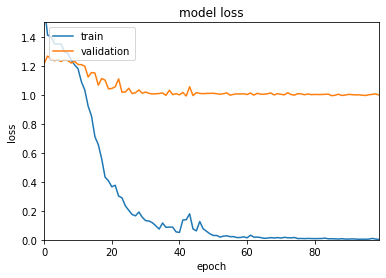

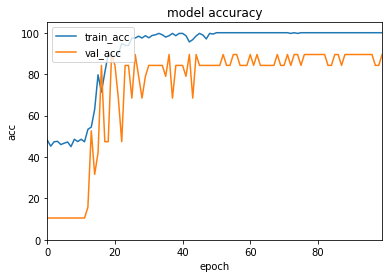

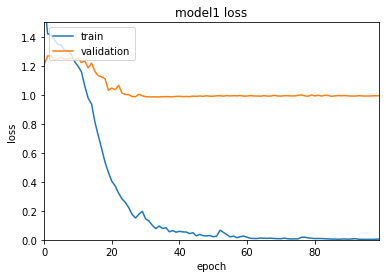

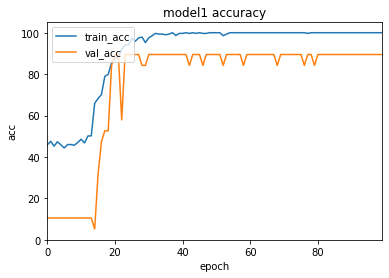

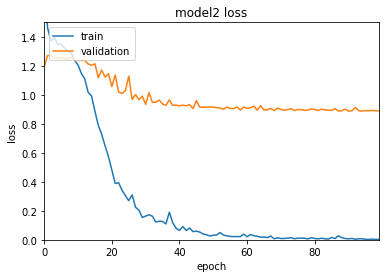

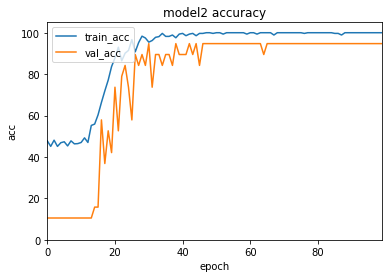

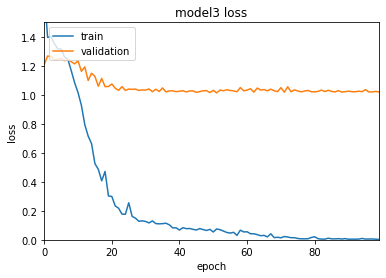

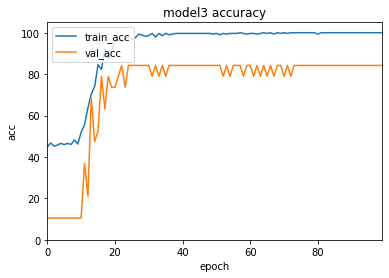

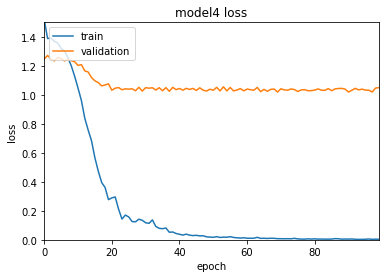

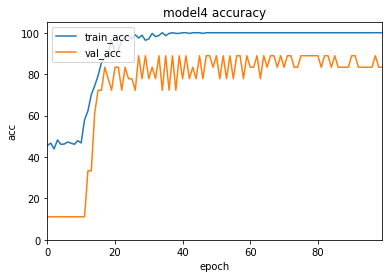

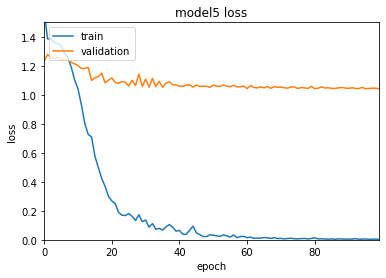

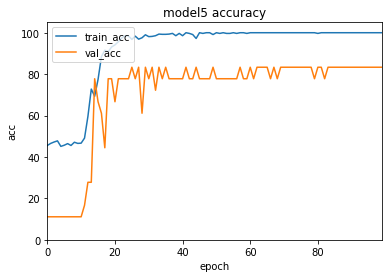

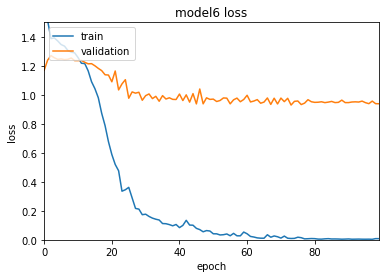

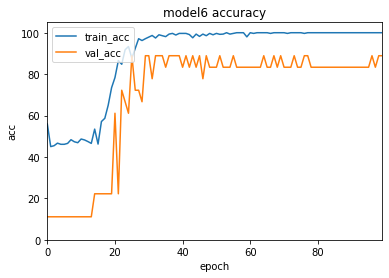

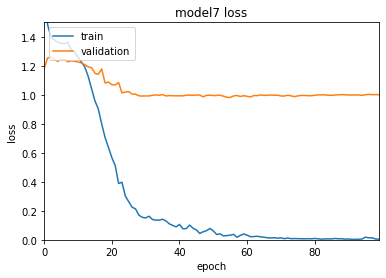

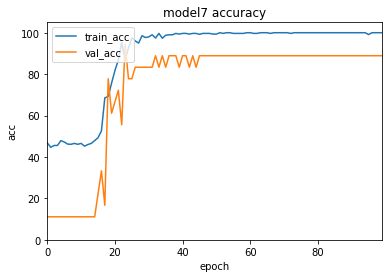

In [23]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


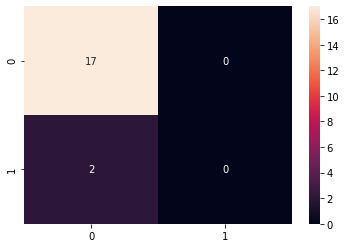

In [24]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  89.47368421052632  PPV |  [0.89473684 0.        ]  Recall |  [1. 0.]


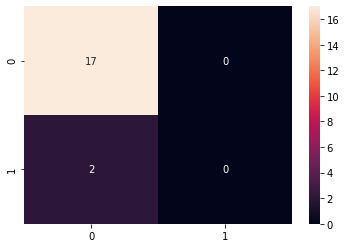

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  94.73684210526315  PPV |  [0.94444444 1.        ]  Recall |  [1.  0.5]


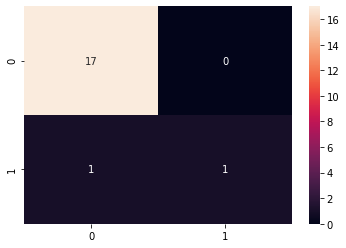

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  84.21052631578947  PPV |  [0.88888889 0.        ]  Recall |  [0.94117647 0.        ]


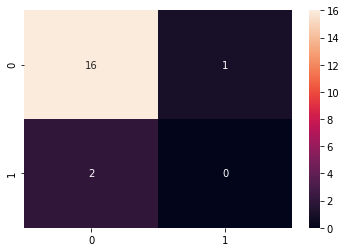

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]


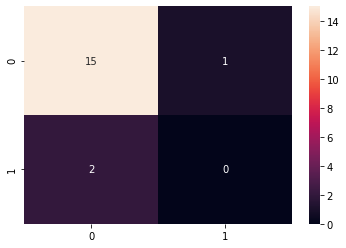

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  83.33333333333334  PPV |  [0.88235294 0.        ]  Recall |  [0.9375 0.    ]


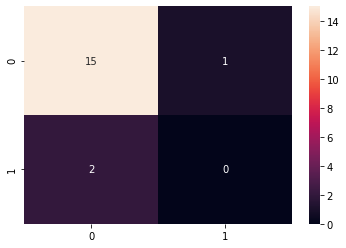

In [29]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  88.88888888888889  PPV |  [0.9375 0.5   ]  Recall |  [0.9375 0.5   ]


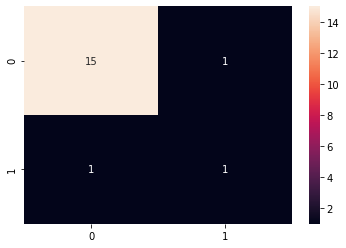

In [30]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  88.88888888888889  PPV |  [0.88888889 0.        ]  Recall |  [1. 0.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


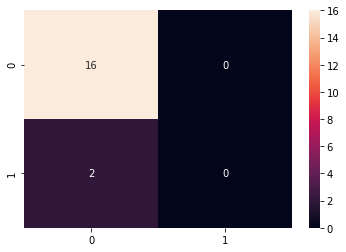

In [31]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [32]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

[[128   4]
 [ 14   2]]
Positive Predictive Value tp/(tp+fp):  0.3333333333333333
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.8783783783783784
Recall Value tp/(tp+fn):  0.125


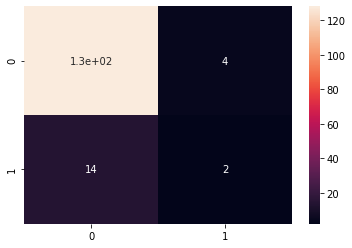

In [33]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 